In [13]:
#=
ビームデータがないwaferについて，対称なwaferにミラーリングしてビームデータを採用するプログラムに変更
ビームを対称にミラーリングするプログラム
ミラーリングしてからビームをシンメトライズし，FWHMを計算する
大枠はできてる
=#
using Pkg
Pkg.activate("/Users/yusuke/program/julia_module/MyPackage")
using MyPackage

using Healpix
using Plots
using NPZ
using LinearAlgebra
using LsqFit
using StatsBase
using BenchmarkTools
using PyCall
using TickTock
using Base.Threads
using StatsPlots
using PyPlot
using DSP
using FFTW
using Formatting
gr()

hp =  pyimport("healpy")
np = pyimport("numpy")
sns = pyimport("seaborn")
plt = pyimport("matplotlib.pyplot")
sp = pyimport("scipy.optimize")
pd = pyimport("pandas")
glob = pyimport("glob")
re = pyimport("re")
os = pyimport("os")
nth = nthreads()# for parallerize

@inline function MultiTrack_calculation(
    NSIDE::Integer,
    start::Integer,
    stop::Integer,
    smp_rate::Integer,
    dθ::Array,
    dφ::Array,
)

    loop = ((stop - start) * smp_rate) + 1

    #println("time=",loop)
    res = Resolution(NSIDE)

    α = 45(π / 180)
    β = 50(π / 180)
    orbit3D = zeros(Float64, loop, 3)
    orbit2D = zeros(Float64, loop, 2)
    dif3D = zeros(Float64, loop-1, 3)
    dif2D = zeros(Float64, loop-1, 2)
    theta_axis3D = zeros(Float64, loop, 3)

    theta_axis = zeros(Float64, loop, 2)
    sky_axis = zeros(Float64, loop, 3)

    pix = zeros(Int64, loop, length(dθ))
    psi_i = zeros(Float64, loop, length(dθ))
    cb = cos(β)
    sb = sin(β)
    ca = cos(α)
    sa = sin(α)
    #println("Start track calculation!")

    for j in eachindex(dθ)
        #println("j=", j)
        #origin =[cos(dθ[j]) * cos(dφ[j]); cos(dθ[j]) * sin(dφ[j]); sin(dθ[j])]
        #=
        origin = [
        cosd(dθ[j]) -sind(dθ[j]) 0
        sind(dθ[j])*cosd(dφ[j]) cosd(dθ[j])*cosd(dφ[j])  -sind(dφ[j])
        sind(dθ[j])*sind(dφ[j]) cosd(dθ[j])*sind(dφ[j])  cosd(dφ[j])
        ]*[1;0;0]
        =#
        origin = [cosd(dθ[j]); sind(dθ[j])cosd(dφ[j]); sind(dθ[j])sind(dφ[j])]

        @inbounds @threads for i in 1:loop
            t = start + (i-1)/smp_rate

            ωₐt = ((2π / 60) / 192.348)t
            ωᵦt = (0.05π / 30)t
            ωᵣt = (2π)t / (60 * 60 * 24 * 365)
            cwb = cos(ωᵦt)
            swb = sin(ωᵦt)
            cwa = cos(ωₐt)
            swa = sin(ωₐt)
            cwr = cos(ωᵣt)
            swr = sin(ωᵣt)

            rot_spin = [
                cb -sb 0
                sb*cwb cb*cwb -swb
                sb*swb cb*swb cwb
            ]
            vec_1 = @views rot_spin * origin

            rot_prec = [
                ca -sa 0
                sa*cwa ca*cwa -swa
                sa*swa ca*swa cwa
            ]
            vec_2 = @views rot_prec * vec_1

            rot_sun = [
                cwr -swr 0
                swr cwr 0
                0 0 1
            ]
            vec_3 = @views rot_sun * vec_2

            orbit3D[i, 1] = vec_3[1]
            orbit3D[i, 2] = vec_3[2]
            orbit3D[i, 3] = vec_3[3]

            ang = @views vec2ang(
                orbit3D[i, 1],
                orbit3D[i, 2],
                orbit3D[i, 3],
            )

            orbit2D[i, 1] = ang[1]
            orbit2D[i, 2] = ang[2]

            theta_axis[i, 1] = orbit2D[i, 1] + (π / 180) * 1e-7

            vec = @views ang2vec(theta_axis[i, 1], orbit2D[i, 2])
            sky_axis[i, 1] = vec[1] - orbit3D[i, 1]
            sky_axis[i, 2] = vec[2] - orbit3D[i, 2]
            sky_axis[i, 3] = vec[3] - orbit3D[i, 3]
            pix[i, j] = ang2pix(m, orbit2D[i, 1], orbit2D[i, 2])
        end

        @inbounds @threads for i in 1:loop-1
            dif3D[i, 1] = orbit3D[i+1, 1] - orbit3D[i, 1]
            dif3D[i, 2] = orbit3D[i+1, 2] - orbit3D[i, 2]
            dif3D[i, 3] = orbit3D[i+1, 3] - orbit3D[i, 3]
            dif2D[i, 1] = orbit2D[i+1, 1] - orbit2D[i, 1]
            dif2D[i, 2] = orbit2D[i+1, 2] - orbit2D[i, 2]

            Vvec = @views dif3D[i, :]
            nvec = @views sky_axis[i, :]
            inner = dot(Vvec, nvec)
            L_dif =
                √(dif3D[i, 1]^2 + dif3D[i, 2]^2 + dif3D[i, 3]^2)
            L_axis = √(
                sky_axis[i, 1]^2 +
                sky_axis[i, 2]^2 +
                sky_axis[i, 3]^2,
            )

            cos_psi = inner / (L_dif * L_axis)

            if dif2D[i, 2] > π
                dif2D[i, 2] = dif2D[i, 2] - 2π
            end
            if dif2D[i, 2] < -π
                dif2D[i, 2] = dif2D[i, 2] + 2π
            end

            judge = sign(-dif2D[i, 2])
            psi_i[i, j] = acos(cos_psi) * judge
        end
    end
    return pix, psi_i
end


function get_psi_and_pix(
    NSIDE::Integer,
    times::Integer,
    smp_rate::Integer,
    dθ::Array,
    dφ::Array,
)

    split_num = 6
    month = Int64(times/split_num)
    Cross = zeros(Float64, (2,4, NPIX))
    hit_pix = zeros(Int64, NPIX)
    theta_line_pix = Int64[]
    theta_line_psi = Float64[]

    Begin = 0
    
    deg = 90(π/180)
    dphi = 20(π/180)

    for i = 1:split_num
        println("process=", i, "/", split_num)
        stop = i*month

        #println("calc_", start, "_to_", stop)
        #println("Finish is =", times)
        PIX, PSI_i = MultiTrack_calculation(NSIDE, Begin, stop, smp_rate, dθ, dφ)

        loop_times = length(PSI_i)
        #println("Start reconstruct!")
        #println("loop_times=", loop_times)
        bore_pix = @views PIX
        #ghost_pix = @views PIX[:, 2]
        psi_i = @views PSI_i
        
        pix_pi2 = hp.pix2ang(NSIDE, bore_pix)[2]
    
        for k in 1:loop_times
            bore = bore_pix[k]
            #ghost = ghost_pix[k]
            psi = psi_i[k]
            TIME = Begin + (k-1)/smp_rate
            
            
            if pix_pi2[k] < deg + dphi
                if pix_pi2[k] > deg - dphi
                    push!(theta_line_pix, bore)
                    push!(theta_line_psi, psi)
                end
            end

            hit_pix[bore] += 1
            bore = PIX[k]
            #println(bore)
            psi = PSI_i[k]
            TIME = Begin + (k-1)/smp_rate
        
            hit_pix[bore] += 1
            Cross[1,1,bore] += sin(psi)
            Cross[2,1,bore] += cos(psi)
            Cross[1,2,bore] += sin(2psi)
            Cross[2,2,bore] += cos(2psi)
            Cross[1,3,bore] += sin(3psi)
            Cross[2,3,bore] += cos(3psi)
            Cross[1,4,bore] += sin(4psi)
            Cross[2,4,bore] += cos(4psi)
        end
        Begin = stop + 1
    end
    link1 = (Cross[1,1,:]./hit_pix).^2 .+ (Cross[2,1,:]./hit_pix).^2
    link2 = (Cross[1,2,:]./hit_pix).^2 .+ (Cross[2,2,:]./hit_pix).^2
    link3 = (Cross[1,3,:]./hit_pix).^2 .+ (Cross[2,3,:]./hit_pix).^2
    link4 = (Cross[1,4,:]./hit_pix).^2 .+ (Cross[2,4,:]./hit_pix).^2
    CrossLinks = [link1,link2,link3,link4]    
    return hit_pix, theta_line_pix, theta_line_psi, CrossLinks
end

function dist_FWHM(copol, theta_line_pix, phi90pix)
    @. gaussian2(x, p) = p[1] * exp(-(1/2)*((x/p[2])^2))
    ddeg = np.deg2rad(0.36)
    FWHM = zeros(length(phi90pix)-2, 4)
    p0 = [136, 0.003]
    xdata = @views [reverse(theta[:,1]) ; -theta[:,500]]
    idx1 = [1, 125, 250, 375]
    idx2 = 500 .+ idx1
    
    for i in 2:99
        if i%10 == 0
            println(i)
        end
        
        index = np.where(theta_line_pix .== phi90pix[i])[1] .+1

        psi_in_ipix = zeros(length(index))
        @threads for i in eachindex(index)
            psi_in_ipix[i] = theta_line_psi[index[i]] 
        end

        copol_sym = MyPackage.rot_beam(psi_in_ipix, copol)
        
        for j in 1:4
            ydata = @views [reverse(copol_sym[:,idx1[j]])  ;copol_sym[:,idx2[j]]]
            Fit = curve_fit(gaussian2, xdata, ydata, p0)
            FWHM[i-1,j] = 60*2*√(2*log(2))* (Fit.param[2])*(180/π)
        end

        #println(FWHM[i])
    end
    return FWHM
end

function hit_map(NSIDE, pix)
    NPIX = nside2npix(NSIDE)
    hit_pix = zeros(Int64, NPIX)
    @threads for i = 1:length(pix)
        hit_pix[pix[i]] += 1
    end
    return hit_pix
end

function flip(pix)
    new_pix = 0
    if pix == 0
        new_pix = 2
    end
    if pix == 2
        new_pix = 0
    end
    if pix == 3
        new_pix = 5
    end
    if pix == 5
        new_pix = 3
    end
    if pix == 6
        new_pix = 8
    end
    if pix == 8
        new_pix = 6
    end
    if pix == 1
        new_pix = 1
    end
    if pix == 4
        new_pix = 4
    end
    if pix == 7
        new_pix = 7
    end
    return new_pix
end


function flip16(n)
    det = Vector(0:1:35)
    det_pix = np.reshape(det, [6,6])
    inv_det = [det_pix[:,6] det_pix[:,5] det_pix[:,4] det_pix[:,3] det_pix[:,2] det_pix[:,1] ]
    idx = np.where(det_pix .== n)
    pixel = inv_det[idx[1][1]+1, idx[2][1]+1]
    return pixel
end

function waferpix2sight(wafer_array, pixel_array)
    loop = length(wafer_array)
    Theta = zeros(loop)
    Phi = zeros(loop)
    beam_path = []
    
    for i in 1:loop
        wafer = wafer_array[i]
        pixel = pixel_array[i]
        switch = 0
        if wafer == 0
            wafer = 3
            pixel = flip(pixel)
            switch += 1
        end
        if wafer == 4
            wafer = 7
            pixel = flip(pixel)
            switch += 1
        end
        
        if wafer == 3 || wafer == 7
            df = pd.read_csv("/Users/yusuke/program/LiteBIRD_sim/beam_study/20200727_pointing_32mm.csv")
        end
        if wafer == 1 || wafer == 5 || wafer == 2 || wafer == 6
            df = pd.read_csv("/Users/yusuke/program/LiteBIRD_sim/beam_study/20200727_pointing_16mm.csv")
        end
        index = np.where((df["wafer"] == wafer) & (df["pixel"] == pixel))[1] .+1
        
        param = df.loc[index[1]]
        theta = param[5]
        phi = param[6]
        
        if wafer == 1
            wafer = 2
            pixel = flip16(pixel)
        end
        if wafer == 5
            wafer = 6
            pixel = flip16(pixel)
        end
        
        index = np.where((df["wafer"] == wafer) & (df["pixel"] == pixel))[1] .+1
        param = df.loc[index[1]]
        name = split(param[1], "Hz")
        name = split(name[1], "_")
        xy_position = name[1]*"_"*name[2]
        
        push!(beam_path, glob.glob("/Users/yusuke/program/LiteBIRD_sim/beam_study/beam_data/beam_data_npz/" * xy_position * "*tp.npz"))
        
        if switch == 0
            if wafer != 0 || wafer != 4
                phi = 180-phi
            end
        end
        Theta[i] = theta
        Phi[i] = phi
    end
    return Theta, Phi, beam_path
end
    

function dist_psi(pixnmb)
    index = np.where(theta_line_pix .== phi90pix[pixnmb])[1] .+1
    psi_in_ipix = zeros(length(index))
    for i in 1:length(index)
        psi_in_ipix[i] = theta_line_psi[index[i]] 
    end
    ddeg = np.deg2rad(0.36)
    ang = round.(np.rad2deg(hp.pix2ang(NSIDE,phi90pix[pixnmb])), sigdigits=3)
    
    println("pix=",ang)

    copol = np.reshape(data["copol"], [N, N])
    copol_sym = MyPackage.rot_beam(psi_in_ipix, copol)

    edge = -180:3:180
    psi_dist = fit(Histogram, np.rad2deg(psi_in_ipix), edge)

    Plots.plot(psi_dist,
        title = "ψᵢ distribution ",
        xlabel="deg",
        label = format("(θ,φ)=({},{})", ang[1], ang[2]),
        seriestype = :step,
        fmt=:png,
    )
end

@. gaussian(x, p) = p[1] * exp(-(1/2)*((x/p[2])^2))

function dist_FWHM(copol, theta_line_pix, phi90pix, p0)
    ddeg = np.deg2rad(0.36)
    FWHM = zeros(length(phi90pix), 4)
    #p0 = [50435, 0.00487]
    xdata = @views [reverse(theta[:,1]) ; -theta[:,500]]
    idx1 = [1, 125, 250, 375]
    idx2 = 500 .+ idx1
    
    for i in eachindex(phi90pix)
        if i%10 == 0
            println(i)
        end
        
        index = np.where(theta_line_pix .== phi90pix[i])[1] .+1

        psi_in_ipix = zeros(length(index))
        @threads for i in eachindex(index)
            psi_in_ipix[i] = theta_line_psi[index[i]] 
        end
        
        if length(psi_in_ipix) != 0
            copol_sym = MyPackage.rot_beam(psi_in_ipix, copol)

            for j in 1:4
                ydata = @views [reverse(copol_sym[:,idx1[j]])  ;copol_sym[:,idx2[j]]]
                Fit = curve_fit(gaussian, xdata, ydata, p0)
                FWHM[i,j] = 60*2*√(2*log(2))* (Fit.param[2])*(180/π)
            end
        end
    end
    loop = length(np.nonzero(FWHM[:,1])[1])
    FWHM_ = zeros(loop, 4)
    for i in 1:loop
        @threads for j in 1:4
            FWHM_[i,j] = FWHM[i+Int((100-loop)/2),j]
        end
    end
    return FWHM_
end

function beam_draw(beam_path, pix_nmb)
    #pix_nmbは0~100まで
    data = npzread(beam_path)
    index = np.where(theta_line_pix .== phi90pix[pix_nmb])[1] .+1
    
    psi_in_ipix = zeros(length(index))

    @threads for i in eachindex(index)
    psi_in_ipix[i] = theta_line_psi[index[i]] 
    end

    N = 1001
    b_phi = np.deg2rad(np.reshape(data["phi"], [N, N]))
    b_theta = np.deg2rad(np.reshape(data["theta"], [N, N]))
    X = b_theta .* cos.( b_phi )
    Y = b_theta .* sin.( b_phi )
    copol = np.reshape(data["copol"], [N, N])
    copol_sym = MyPackage.rot_beam(psi_in_ipix, copol)

    figure(111)
    plt.title("Original beam")
    pcolormesh(X, Y, 10log10.(copol), cmap = "jet" )
    pp = plt.colorbar( orientation ="vertical")
    plt.grid()


    figure(222)
    plt.title("Symmetrized beam")
    pcolormesh(X, Y, 10log10.(copol_sym), cmap = "jet" )
    pp = plt.colorbar( orientation ="vertical")
    plt.grid()
end


function dist_FWHM(beam_path, theta_line_pix, phi90pix)
    ddeg = np.deg2rad(0.36)
    beam_nmb = length(beam_path)
    
    FWHM = zeros(length(phi90pix), 4)
    FWHM_dist = zeros(400, beam_nmb)
    #p0 = [50435, 0.00487]
    
    idx1 = [1, 125, 250, 375]
    idx2 = idx1 .+ 500
    
    for k in 1:beam_nmb
        
        data = npzread(beam_path[k])
        println(beam_path[k])
        b_phi = np.deg2rad(np.reshape(data["phi"], [N, N]))
        b_theta = np.deg2rad(np.reshape(data["theta"], [N, N]))
        copol = np.reshape(data["copol"], [1001, 1001])
        xdata = @views [reverse(b_theta[:,1]) ; -b_theta[:,500]]
        for i in eachindex(phi90pix)
            if i%10 == 0
                println(i)
            end
        
            index = np.where(theta_line_pix .== phi90pix[i])[1] .+1
    
            psi_in_ipix = zeros(length(index))
            @threads for i in eachindex(index)
                psi_in_ipix[i] = theta_line_psi[index[i]] 
            end
        
            if length(psi_in_ipix) != 0
                copol_sym = MyPackage.rot_beam(psi_in_ipix, copol)

                @threads for j in 1:4
                    ydata = @views [reverse(copol_sym[:,idx1[j]])  ;copol_sym[:,idx2[j]]]
                    p0 = [findmax(ydata)[1], 0.01]
                    Fit = curve_fit(gaussian, xdata, ydata, p0)
                    FWHM[i,j] = 60*2*√(2*log(2))* (Fit.param[2])*(180/π)
                end
            end
        end

        fwhm_dist = np.ravel(FWHM)
        #println(length(fwhm_dist))
        #println(fwhm_dist)
        
        @threads for i in eachindex(fwhm_dist)
            FWHM_dist[i,k] = fwhm_dist[i]
        end
    end
    return FWHM_dist
end

 Activating environment at `~/program/julia_module/MyPackage/Project.toml`


dist_FWHM (generic function with 2 methods)

In [107]:
const NSIDE = 128
const NPIX = nside2npix(NSIDE)
const m = Map{Float64,RingOrder}(NSIDE)
const day = 60 * 60 * 24
const year = day * 365
smp_rate = 5
times = year
prec1 = 60*60*3
println("SR=", smp_rate)

WFFP = Int[]
PXFP = Int[]
for i in 0:7
    nmb = 35
    if i == 0 || i == 3 || i == 4 || i == 7
        nmb = 8
    end
    for j in 0:nmb
        push!(WFFP, i)
        push!(PXFP, j)
    end
end

Wafer = [3]
Pixel = [2]


SR=5


1-element Array{Int64,1}:
 2

In [9]:
div = 100
WF_LFT_edge = [0,3,7,4]
PX_LFT_edge = [0,2,8,6]
th, ph, bpath = waferpix2sight(WFFP, PXFP)

elev = np.linspace(0, π, div)
azim = ones(div) .* π / 2
phi90pix = hp.ang2pix(NSIDE, elev, azim) .+1
div

100

In [14]:
dth, dph, beam_path = waferpix2sight([3], [2])
hit_pix, theta_line_pix, theta_line_psi, CrossLinks = get_psi_and_pix(NSIDE, times, smp_rate, dth, dph)

┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = waferpix2sight(::Array{Int64,1}, ::Array{Int64,1}) at In[13]:364
└ @ Main ./In[13]:364
┌ Warning: `getindex(o::PyObject, s::AbstractString)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o."s"` instead of `o["s"]`.
│   caller = waferpix2sight(::Array{Int64,1}, ::Array{Int64,1}) at In[13]:364
└ @ Main ./In[13]:364
┌ Warning: `getindex(o::PyObject, i::Integer)` is deprecated, use `get(o, i - 1)` instead.
│   caller = waferpix2sight(::Array{Int64,1}, ::Array{Int64,1}) at In[13]:366
└ @ Main ./In[13]:366
┌ Warning: `getindex(o::PyObject, i::Integer)` is deprecated, use `get(o, i - 1)` instead.
│   caller = waferpix2sight(::Array{Int64,1}, ::Array{Int64,1}) at In[13]:367
└ @ Main ./In[13]:367
┌ Warning: `getindex(o::PyObject, i::Integer)` is 

process=1/6
process=2/6
process=3/6
process=4/6
process=5/6
process=6/6


([2128, 2136, 2102, 2118, 2102, 2094, 2136, 2138, 2120, 2134  …  2148, 2160, 2114, 2086, 2128, 2134, 2138, 2096, 2112, 2138], [91028, 91028, 91028, 90517, 90004, 90004, 90004, 90004, 90004, 90004  …  2022, 2022, 1897, 1897, 1897, 1897, 1897, 1897, 1776, 1776], [3.1028350429069236, 3.102396448210303, 3.101957890888419, 3.101519175792488, 3.1010803472868442, 3.1006413891619693, 3.100202487670144, 3.0997634151827596, 3.09932421165199, 3.0988849584376  …  -2.394119072289164, -2.391313152409875, -2.388484976491722, -2.385634316355855, -2.382761023728603, -2.379864911171566, -2.3769457773222036, -2.3740034675401738, -2.371037776487099, -2.3680485064227463], [[9.45398026183431e-6, 6.489308161682291e-7, 0.00022142005129836674, 2.3915448540966543e-6, 5.1064004467770715e-5, 9.787009471715733e-5, 6.457891771611586e-5, 6.211329482667956e-5, 9.084845686003503e-5, 0.0001543150169201812  …  5.131509564402642e-5, 0.0001048164136499446, 3.545449777436686e-5, 0.00014840595091778175, 7.104948983167463e-6

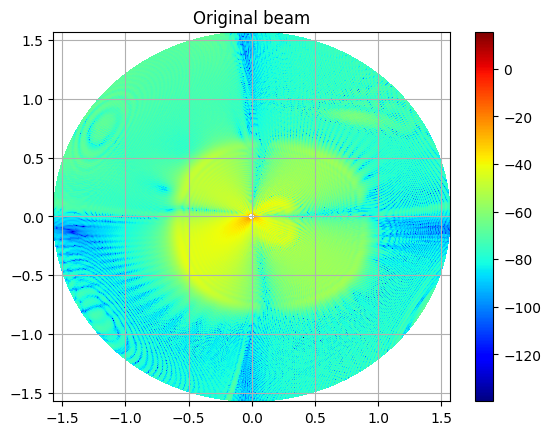

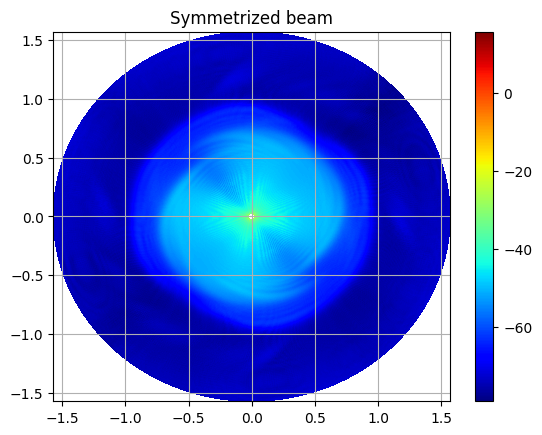

In [120]:
beam_draw(beam_path[1][1], 50)

[257015.23131209865, 0.002780446091672413]
FWHM=22.508475750291606


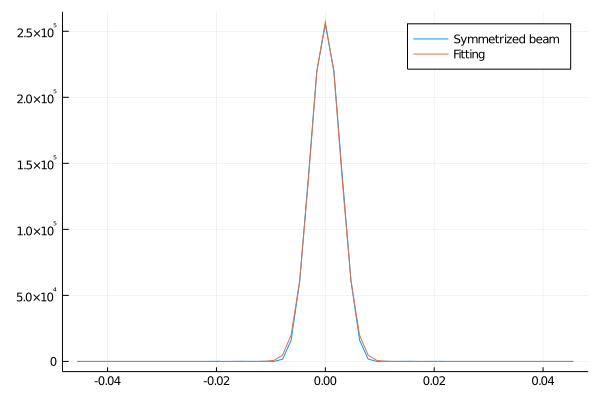

In [63]:
#=
data = npzread("/Users/yusuke/program/LiteBIRD_sim/beam_study/beam_data/beam_data_npz/m12_m92_140G_000deg_tp.npz")
copol = np.reshape(data["copol"], [N, N])
copol_sym = MyPackage.rot_beam(psi_in_ipix, copol)

cut=30
a = [reverse(copol_sym[1:cut,1])  ;copol_sym[1:cut,501]]
b = [reverse(b_theta[1:cut,1]) ; -b_theta[1:cut,501]]


xdata = b
ydata = a
p0 = [findmax(ydata)[1], 0.01]
Fit = curve_fit(gaussian, xdata, ydata, p0)
println(Fit.param)

gauss = gaussian(xdata, Fit.param)
FWHM = 2*√(2*log(2))*Fit.param[2]
println("FWHM=", np.rad2deg(FWHM)*60)
Plots.plot(xdata, ydata, label = "Symmetrized beam", fmt=:png)
Plots.plot!(xdata, gauss, label = "Fitting")
=#

In [79]:
fwhm = dist_FWHM(beam_path[1], theta_line_pix, phi90pix)

/Users/yusuke/program/LiteBIRD_sim/beam_study/beam_data/beam_data_npz/m189_p84_89.0G_000deg_tp.npz
10
20
30
40
50
60
70
80
90
100
/Users/yusuke/program/LiteBIRD_sim/beam_study/beam_data/beam_data_npz/m189_p84_50.0G_000deg_tp.npz
10
20
30
40
50
60
70
80
90
100
/Users/yusuke/program/LiteBIRD_sim/beam_study/beam_data/beam_data_npz/m189_p84_68.0G_000deg_tp.npz
10
20
30
40
50
60
70
80
90
100


400×3 Array{Float64,2}:
  0.0      0.0      0.0
  0.0      0.0      0.0
  0.0      0.0      0.0
  0.0      0.0      0.0
  0.0      0.0      0.0
  0.0      0.0      0.0
  0.0      0.0      0.0
  0.0      0.0      0.0
 42.2334  58.7146  47.5983
 42.2481  58.6696  47.5874
 42.2009  58.6439  47.5514
 42.1854  58.6872  47.5618
 42.2302  58.6774  47.5813
  ⋮                
 42.2643  58.6212  47.5739
 42.1483  58.6098  47.511
 42.1676  58.7414  47.5736
 42.287   58.7408  47.6395
  0.0      0.0      0.0
  0.0      0.0      0.0
  0.0      0.0      0.0
  0.0      0.0      0.0
  0.0      0.0      0.0
  0.0      0.0      0.0
  0.0      0.0      0.0
  0.0      0.0      0.0

In [85]:
FWHM1 = Float64[]
FWHM2 = Float64[]
FWHM3 = Float64[]
for i in 1:400
    if fwhm[i,1] != 0
        push!(FWHM1, fwhm[i,1])
    end
end
for i in 1:400
    if fwhm[i,2] != 0
        push!(FWHM2, fwhm[i,2])
    end
end
for i in 1:400
    if fwhm[i,3] != 0
        push!(FWHM3, fwhm[i,3])
    end
end

In [100]:
split(split(beam_path[1][1], "/")[end], "_")[3]

"89.0G"

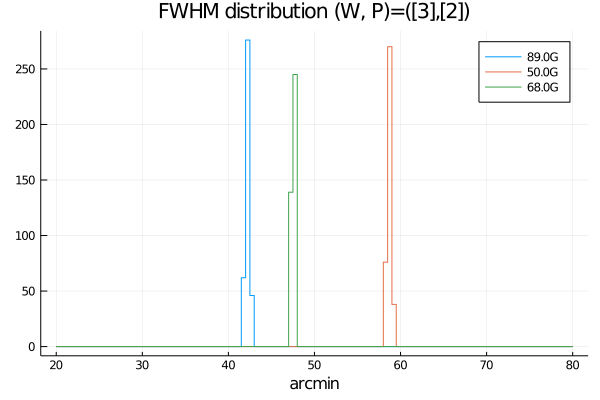

In [108]:
edge = 20:0.5:80
fwhm_dist1 = fit(Histogram, FWHM1, edge)
fwhm_dist2 = fit(Histogram, FWHM2, edge)
fwhm_dist3 = fit(Histogram, FWHM3, edge)
#format("(θ,φ)=({},{})", ang[1], ang[2]),
dataname1 = split(split(beam_path[1][1], "/")[end], "_")[3]
dataname2 = split(split(beam_path[1][2], "/")[end], "_")[3]
dataname3 = split(split(beam_path[1][3], "/")[end], "_")[3]

Plots.plot([fwhm_dist1, fwhm_dist2, fwhm_dist3],
    title = format("FWHM distribution (W, P)=({},{})", Wafer, Pixel),
    xlabel="arcmin",
    label = [dataname1 dataname2 dataname3],
    seriestype = :step, fmt=:png)

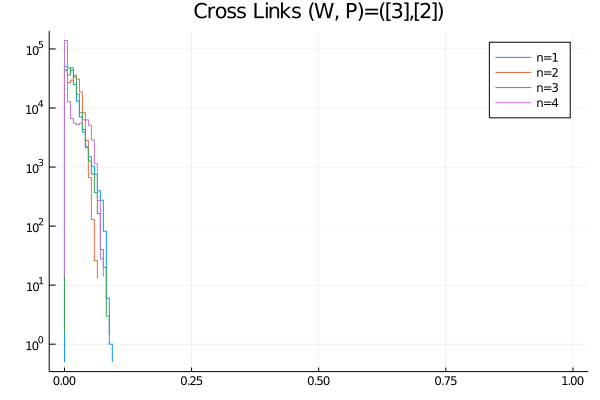

In [109]:
link1 = np.nan_to_num(CrossLinks[1],nan=-0.1)
link2 = np.nan_to_num(CrossLinks[2],nan=-0.1)
link3 = np.nan_to_num(CrossLinks[3],nan=-0.1)
link4 = np.nan_to_num(CrossLinks[4],nan=-0.1)
BINS=170
edge = 0:1/BINS:1
l1 = fit(Histogram, link1, edge)
l2 = fit(Histogram, link2, edge)
l3 = fit(Histogram, link3, edge)
l4 = fit(Histogram, link4, edge)

Plots.plot([l1,l2,l3,l4],
    title = format("Cross Links (W, P)=({},{})", Wafer, Pixel),
    label = ["n=1" "n=2" "n=3" "n=4"],
    seriestype = :step, yaxis=:log, fmt=:png)

In [239]:
savepath = "/Users/yusuke/program/LiteBIRD_sim/beam_study/beam_data/calc_fwhm_dist/"
np.savez_compressed(savepath * main_name * "_fwhm", data=FWHM_)

In [240]:
a = npzread(savepath * main_name * "_fwhm" * ".npz")
a["data"]

98×4 Array{Float64,2}:
 43.8377  43.8495  43.8519  43.8401
 43.8547  43.8103  43.8343  43.8799
 43.8799  43.8337  43.81    43.8561
 43.8765  43.8444  43.8142  43.8452
 43.9506  43.7949  43.7402  43.8943
 44.0774  43.7205  43.6158  43.9659
 43.7266  43.8619  43.9551  43.8366
 43.6492  43.9576  44.0352  43.7403
 43.6183  43.9821  44.0684  43.7133
 43.534   43.9626  44.1544  43.7311
 43.5195  43.9838  44.1704  43.7091
 43.5678  43.9799  44.1269  43.7083
 43.5006  43.9635  44.1906  43.7275
  ⋮                         
 43.5095  43.9556  44.1808  43.7376
 43.5821  43.9017  44.106   43.7926
 43.6459  44.0082  44.0411  43.6877
 43.5409  43.896   44.1441  43.8001
 43.6879  43.9784  43.9942  43.7201
 43.7551  43.8273  43.9262  43.8698
 44.1278  43.744   43.5614  43.9414
 43.958   43.8381  43.7305  43.8501
 43.8912  43.816   43.7973  43.873
 43.8676  43.8582  43.8213  43.8314
 43.8561  43.8172  43.833   43.8721
 43.8536  43.8649  43.836   43.824